<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:lightblue;
            overflow:hidden;
            font-weight:500"> RAG - Harry Potter Q&A</div>

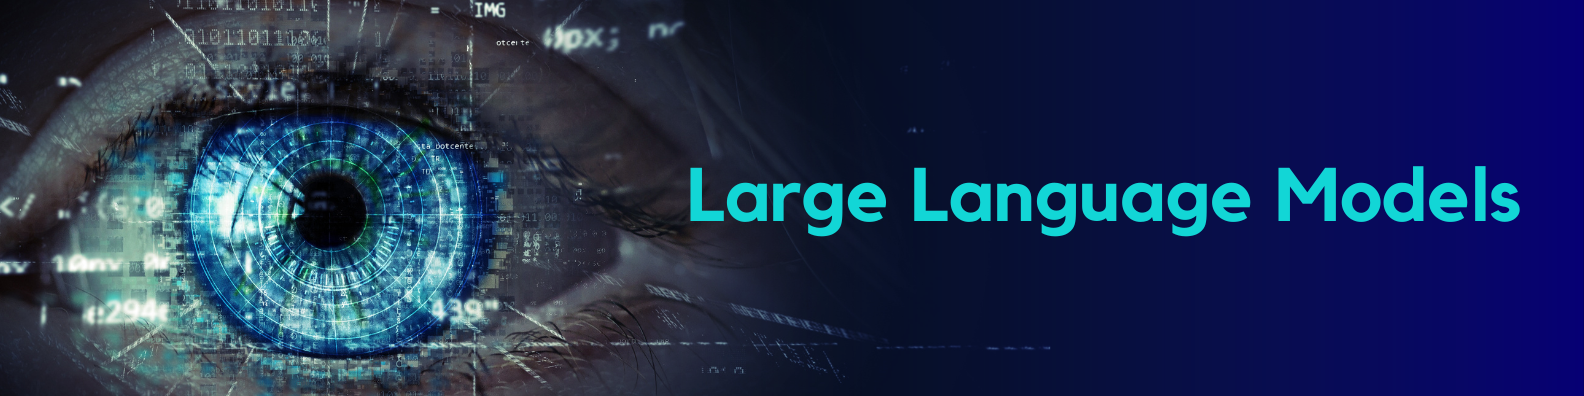

  <div style="padding:20px; 
              color:blue;
              margin:10px;
              font-size:150%;
              text-align:center;
              display:fill;
              border-radius:20px;
              border-width: 5px;
              background-color:#eca912;
              overflow:hidden;
              font-weight:500">
    <b>INTRODUCTION</b>
  </div>

This notebook contains a full Q&A pipeline using llama index framework and Deeplake as vector database. The data used are Harry Potter books that have been extracted from **[Kaggle](https://www.kaggle.com/datasets/hinepo/harry-potter-books-in-pdf-1-7)**. For the following pipeline only 2 books where used due to memory and API KEY tokens limitations. 

The main steps taken to build the RAG pipeline can be summarize as follows (a basic RAG Pipeline is performed after text cleaning):

* **Data Ingestion**: import data into the notebook

* **Text Cleaning**: replacing multiple consecutive spaces

* **Nodes**: sentence splitter and windows parser

* **Indexing**: VectorStoreIndex for indexing chunked nodes with associated service and storage contexts

* **Postprocessing**: single sentences are replaced with a window containing the surrounding sentences

* **Reranking**: re-order nodes, and returns the top N nodes

* **Scoring**: top k most similar results

* **Evaluation**: relevancy and faithfulness based on questions generated with the `generate_question_context_pairs` function


  <div style="padding:20px; 
              color:blue;
              margin:10px;
              font-size:150%;
              text-align:center;
              display:fill;
              border-radius:20px;
              border-width: 5px;
              background-color:#eca912;
              overflow:hidden;
              font-weight:500">
    <b>CONTACT INFORMATION</b>
  </div>

If you like this project, feel free to copy this notebook an make your own RAG Project. You can also contact me through LinkedIn or follow my GitHub:

**Benito Martin:** 

- [GitHub](https://github.com/benitomartin) 🔗

- [LinkedIn](https://www.linkedin.com/in/benitomzh/) 🔗

  <div style="padding:20px; 
              color:blue;
              margin:10px;
              font-size:150%;
              text-align:center;
              display:fill;
              border-radius:20px;
              border-width: 5px;
              background-color:#eca912;
              overflow:hidden;
              font-weight:500">
    <b>TABLE OF CONTENTS</b>
  </div>

* [1. Import Libraries](#lib)
   
* [2. Get API Keys](#keys)

* [3. Data Ingestion and Preprocessing](#data)

    * [3.1. Get Data](#get)

    * [3.2. Text Cleaning](#clean)

    * [3.3. Merging Documents](#merge)

* [4. Basic RAG Pipeline](#basic)
  
    * [4.1. Indexing Documents](#index)

    * [4.2. Basic Query Retrieval](#query)

* [5. LLama Index: Deeplake RAG Pipeline](#deeplake)

    * [5.1. Nodes](#nodes)

        * [5.1.1. Sentence Splitter](#split)

        * [5.1.2. Sentence Window Node Parser](#window)

    * [5.2. Indexing](#index2)

    * [5.3. Post Processing](#post)
 
    * [5.4. Reranking](#rank)

    * [5.4. Query Engine](#engine)

* [6. Model Evaluation](#model)

    * [6.1. Generate Questions](#questions)

    * [6.2. Evaluation](#evaluation)
 
* [7. Further Steps](#steps)

# <font color='289C4E'>1. Import Libraries 📚<font><a class='anchor' id='lib'></a>

In [1]:
# Global
import os
import getpass
import textwrap
import time
import locale
import json
import re
import torch
from time import time
import json

# Llama Index
from llama_index import SimpleDirectoryReader, Document, VectorStoreIndex, ServiceContext, StorageContext
from llama_index.llms import OpenAI
from llama_index.node_parser import SimpleNodeParser, SentenceWindowNodeParser
from llama_index.vector_stores import DeepLakeVectorStore
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.evaluation import generate_question_context_pairs, CorrectnessEvaluator, RelevancyEvaluator, FaithfulnessEvaluator, BatchEvalRunner, RetrieverEvaluator
from llama_index.embeddings.cohereai import CohereEmbedding
from llama_index.text_splitter import SentenceSplitter
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor, SentenceTransformerRerank
from llama_index.finetuning.embeddings.common import EmbeddingQAFinetuneDataset

# OpenAI
import openai
from openai import OpenAI

# Warnings
import warnings
warnings.filterwarnings("ignore")

# <font color='289C4E'>2. Get API Keys 🗝️<font><a class='anchor' id='keys'></a>

In [2]:
if torch.cuda.is_available:
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

GPU available


In [11]:
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


# <font color='289C4E'>3. Data Ingestion and Preprocessing 📖<font><a class='anchor' id='data'></a>

## <font color='289C4E'>3.1. Get Data 📔<font><a class='anchor' id='get'></a>

The first step is to get our data. We will use the **SimpleDirectoryReader**, which will select the best file reader based on the file extensions.



In [4]:
# Define the folder path where data is stored
data_folder = "./data/"

# Create a SimpleDirectoryReader object to read data from the specified folder
reader = SimpleDirectoryReader(
    input_dir=data_folder,  # Set the input directory
    recursive=True,  # Enable recursive scanning through subdirectories
)

# Create an empty list to store all documents
documents = []

# Iterate through the data returned by the reader and append each document to the 'documents' list
for docs in reader.iter_data():
    for doc in docs:
        documents.append(doc)


In [5]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0:4])

<class 'list'> 

601 

<class 'llama_index.schema.Document'>
[Document(id_='7acc381b-c1e1-4bd6-b62a-48191b688c66', embedding=None, metadata={'page_label': '1', 'file_name': 'Harry Potter - Book 1 - The Sorcerers Stone.pdf', 'file_path': 'data\\Harry Potter - Book 1 - The Sorcerers Stone.pdf', 'file_type': 'application/pdf', 'file_size': 1049997, 'creation_date': '2024-01-05', 'last_modified_date': '2023-12-30', 'last_accessed_date': '2024-01-06'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='fc9700d8723c56a9415dee8fbefef8c2946f925b547d3f428ac6c5d7fc0db462', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), Document(id_='f2e101b9-45bb-4bdc-8b03-20a

## <font color='289C4E'>3.2. Text Cleaning 🧹<font><a class='anchor' id='clean'></a>

The PDF has been converted to a list of 601 elements. We also see that the text of our data shows multiple consecutive spaces. This will require a cleaning step to preprocess the text.

We will do it so, removing multiple consecutive spaces.

In [6]:
# Function to clean text by replacing multiple consecutive spaces with a single space
def clean_text(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text

# List comprehension to clean the text of each document in the 'documents' list
cleaned_documents = [clean_text(doc.text) for doc in documents]

In [7]:
print(type(cleaned_documents), "\n")
print(len(cleaned_documents), "\n")
print(type(cleaned_documents[0]))
print(cleaned_documents[0:4])

<class 'list'> 

601 

<class 'str'>
['', '', "HP 1 - Harry Potter and the Sorcerer's Stone Harry Potter and the Sorcerer's Stone Harry Potter & The Sorcerer’s Stone by J.K. Rowling ", "HP 1 - Harry Potter and the Sorcerer's Stone"]


Now our text looks better, as the spaces has been removed

## <font color='289C4E'>3.3. Merging Documents 🤼‍♂️🤼‍♂<font><a class='anchor' id='merge'></a>

Let's put all documents together in a single one, creating a document object with the **Document** class.

In [8]:
# Merging Documents
document = Document(text="\n\n".join([doc for doc in cleaned_documents]))

text_content = document.get_text()
print(type(document))
print(text_content[:500])

<class 'llama_index.schema.Document'>




HP 1 - Harry Potter and the Sorcerer's Stone Harry Potter and the Sorcerer's Stone Harry Potter & The Sorcerer’s Stone by J.K. Rowling 

HP 1 - Harry Potter and the Sorcerer's Stone

CHAPTER ONE THE BOY WHO LIVED M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mr. Dursley was the


# <font color='289C4E'>4. Basic RAG Pipeline 🎡<font><a class='anchor' id='basic'></a>

## <font color='289C4E'>4.1. Indexing Documents 📇<font><a class='anchor' id='index'></a>

Indexing is a fundamental process for storing and organizing data from diverse sources into a vector store (**VectorStoreIndex**), a structure essential for efficient storage and retrieval (**ServiceContext** incorporates necessary configurations or services needed to generate vector representations). This process involves storing **text chunks** along with their corresponding **embedding** representations, capturing the **semantic meaning** of the text. These embeddings facilitate easy retrieval of chunks based on their semantic similarity. Embeddings are typically generated by specialized models like `BAAI/bge-small-en-v1.5` (Flag Embedding which is focused on RAG LLMs).

In [9]:
# Imports required in this cell (otherwise it will show an error)
from llama_index import VectorStoreIndex
from llama_index import ServiceContext
from llama_index.llms import OpenAI

# Initialize an OpenAI language model (llm) with specific configurations
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1) # 0 to 2. When you set it higher, you'll get more random outputs.
                                                     # When you set it lower, towards 0, the values are more deterministic.

# Create a ServiceContext object with default configurations
# This context incorporates required settings and services for generating vector representations
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model="local:BAAI/bge-small-en-v1.5") # Flag Embedding: focus on RAG LLMs.


# Create a VectorStoreIndex object by indexing the 'document' (text data) using the provided service context
index = VectorStoreIndex.from_documents(
    [document],  # List containing the document(s) to be indexed
    service_context=service_context)  # Incorporates the context for vector generation and indexing


## <font color='289C4E'>4.2. Basic Query Retrieval ❔<font><a class='anchor' id='query'></a>

Let's try to make a question and check the output text. We will compare later with other models.

In [12]:
# Initiate Query Engine
query_engine = index.as_query_engine()

# Submit a Query String
response = query_engine.query(
    "Which are the main characters of the book?")

print(str(response))

The main characters of the book are Harry Potter, Ron Weasley, Hermione Granger, Hagrid, Professor McGonagall, and Dumbledore.


# <font color='289C4E'>5. LLama Index: Deeplake RAG Pipeline 🌊<font><a class='anchor' id='deeplake'></a>

## <font color='289C4E'>5.1. Nodes 🔠<font><a class='anchor' id='nodes'></a>

When passing documents to a vector store for indexing, there are two main alternatives:

**1. Passing the Whole Document:**

- Involves indexing the entire document as a single unit.
- Suitable for smaller documents that fit comfortably within memory constraints.
- Simpler indexing process but might lack granularity in capturing diverse content within larger documents.

**2. Converting the Document into Nodes:**

- Breaks down the document into smaller, manageable chunks or nodes.
- Ideal for larger documents to prevent memory issues and for better granularity.
- Enables indexing of specific sections or segments, improving the ability to capture diverse content within the document.

As a general guideline, for larger documents, it's advantageous to break them down into smaller chunks or nodes before indexing. This approach not only helps in avoiding memory limitations but also allows for a more detailed and nuanced representation of the document's content. It facilitates better indexing granularity, potentially enhancing the retrieval and analysis of specific sections within the larger document.

### <font color='289C4E'>5.1.1. Sentence Splitter 🪓<font><a class='anchor' id='split'></a>

LlamaIndex features a **NodeParser** class designed to convert the content of documents into structured nodes automatically. The **SentenceSplitter** allows to break down your documents into sentences. This will require a pattern to decide where a sentence starts or stops (bullet points, points,..)


In [ ]:
# Create a SimpleNodeParser for parsing nodes from text content
sentence_node_parser = SentenceSplitter.from_defaults(
    paragraph_separator=r"\n(?:●|-|\s{2,}|\.\s|？|！)\n",  # Regular expression pattern for paragraph separation
    chunk_size=512,
    include_prev_next_rel=True,   # Include previous and next relationships for nodes
    include_metadata=True         # Include metadata for nodes (such as document information)
)

In [ ]:
# Get nodes from the cleaned documents using the sentence_node_parser
sentence_nodes = sentence_node_parser.get_nodes_from_documents([document])

# Print information about the data and nodes
print(f"Number of Documents: {len(cleaned_documents)}")  # Assuming 'cleaned_documents' contains preprocessed data
print(f"Number of nodes: {len(sentence_nodes)} with the current chunk size of {sentence_node_parser.chunk_size}")


Number of Documents: 601
Number of nodes: 766 with the current chunk size of 512


### <font color='289C4E'>5.1.2. Sentence Window Node Parser 🪟<font><a class='anchor' id='window'></a>

However, there is another Nodeparser which enhance the SentenceSplitter, the  **SentenceWindowNodeParser**. This splits a document into nodes, with each node being a sentence. Each node contains a window from the surrounding sentences in the metadata. Additionally, it contains a sentence splitter argument.

In [ ]:
# Define a function that splits sentences based on the provided regular expression pattern
def custom_sentence_splitter(text):
    # Apply the regex pattern to split sentences
    sentences = re.split(r"\n(?:●|-|\s{2,}|\.\s|？|！)\n", text)
    return sentences

# Use the defined function as the sentence splitter
window_parser = SentenceWindowNodeParser.from_defaults(
    sentence_splitter=custom_sentence_splitter,  # Pass the callable function or list of functions
    window_size=3,
    include_prev_next_rel=True,
    include_metadata=True
)

window_nodes = window_parser.get_nodes_from_documents([document])

In [ ]:
# Print the nodes text
print([x.text for x in window_nodes])
print(window_nodes[1].metadata["original_text"])
print(window_nodes[1].metadata["window"])

## <font color='289C4E'>5.2. Indexing 🗂️<font><a class='anchor' id='index2'></a>

Let's now perform the indexing as before, but this time passing the nodes. As the OpenAI model has a maximum of 8192 tokens we will perform the Query in chunks.

In [ ]:
# Define a function to chunk the original text
def chunk_text(text, max_tokens_per_chunk):
    chunked_text = []
    current_chunk = []
    current_chunk_token_count = 0

    # Extract text from the document
    tokens = text.split()  # Tokenize the original text

    for token in tokens:
        if current_chunk_token_count + len(token) < max_tokens_per_chunk:
            current_chunk.append(token)
            current_chunk_token_count += len(token)
        else:
            chunked_text.append(" ".join(current_chunk))
            current_chunk = [token]
            current_chunk_token_count = len(token)

    if current_chunk:
        chunked_text.append(" ".join(current_chunk))

    return chunked_text

In [ ]:
# Imports required in this cell (otherwise it will show an error)
from llama_index import VectorStoreIndex
from llama_index import ServiceContext
from llama_index.llms import OpenAI
from llama_index.schema import Node  # Import the Node class


# Initialize an OpenAI language model (LLM) for question answering
llm = OpenAI(model="gpt-3.5-turbo-1106")

# Define a local path for storing vectors using DeepLakeVectorStore
dataset_path = "/content/nodes/deep_lake_db"

# Create a DeepLakeVectorStore instance for vector storage with specified configurations
vector_store = DeepLakeVectorStore(
    dataset_path=dataset_path,  # Path to store vectors
    overwrite=True,  # Overwrite if the dataset exists
    exec_option="compute_engine"  # Execution option (e.g., compute engine)
)

# Define an embedding model (text-embedding-ada-002) from OpenAI
embed_model = OpenAIEmbedding()

# Create a ServiceContext incorporating the embedding model and the LLM
service_context = ServiceContext.from_defaults(embed_model=embed_model, llm=llm)

# Create a StorageContext incorporating the vector store for storage
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Define the maximum token count per chunk
max_tokens_per_chunk = 8192  # Limit of the model

# Chunk the nodes
chunked_document = chunk_text(document.get_text(), max_tokens_per_chunk)

# Initialize an empty list to store nodes
window_nodes = []

# Iterate through each chunk in chunked_document
for index, chunk in enumerate(chunked_document):
    # Create a Document object for each chunk of text
    doc = Document(text=chunk, id_=str(index))  # Assign a unique ID to each document
    # Create nodes from the Document object
    nodes_from_chunk = window_parser.get_nodes_from_documents([doc])
    # Extend the window_nodes list with nodes from the current chunk
    window_nodes.extend(nodes_from_chunk)

# Create a VectorStoreIndex for indexing chunked nodes with associated service and storage contexts
vector_index = VectorStoreIndex(
    window_nodes,
    service_context=service_context)


## <font color='289C4E'>5.3. Post Processing 📥<font><a class='anchor' id='post'></a>

Then, during retrieval, before passing the retrieved sentences to the LLM, the single sentences are replaced with a window containing the surrounding sentences using the **MetadataReplacementNodePostProcessor**.

In [ ]:
# Create a MetadataReplacementPostProcessor instance
postproc = MetadataReplacementPostProcessor(
    target_metadata_key="window"  # Specifies the target metadata key for replacement
)


## <font color='289C4E'>5.4. Reranking 🎖️<font><a class='anchor' id='rank'></a>

The **SentenceTransformerRerank** uses the cross-encoders from the sentence-transformer package to re-order nodes, and returns the top N nodes.

In [6]:
# Create a SentenceTransformerRerank instance
rerank = SentenceTransformerRerank(
    top_n=3, model="BAAI/bge-reranker-base"
)

## <font color='289C4E'>5.5. Query Engine 🚒<font><a class='anchor' id='engine'></a>

Now we are ready for our query. We will retrieve the top 10 most similar results and the score of the first 3 ones.

In [ ]:
# Create a query engine based on the vector index, with post-processing steps
query_engine = vector_index.as_query_engine(
    similarity_top_k=10,                   # Retrieve the top 10 most similar results
    node_postprocessors=[postproc, rerank] # Apply post-processing techniques (postproc and rerank) to the retrieved nodes
)

# Record the current time
now = time()

# Execute a query using the prepared query engine
response = query_engine.query(
    "Which are the main characters of the book?",  # Query asking about the main characters of a book
)

# Calculate and print the elapsed time for the query execution
print(f"Elapsed: {round(time() - now, 2)}s")


Elapsed: 23.92s


Here we will check the the **score** of our query. The score represents the relevance or similarity measure between the query and the retrieved document. This score indicates the likelihood or degree to which the document is considered relevant to the query based on the model's understanding or learned representation of the text.

For instance:

- A higher score typically suggests greater relevance or similarity between the query and the document.

- Lower scores imply lesser relevance or similarity.

In [ ]:
# Process the response
if response and response.source_nodes:
    # Print response
    print(response)
    # Accessing and printing the top-k results from source_nodes

    print("Top-K Results:")
    for rank, node_with_score in enumerate(response.source_nodes):
        print(f"{rank + 1}. Score: {node_with_score.score} - Node ID: {node_with_score.node.id_}")
        # Access other metadata or information from the node_with_score as needed
else:
    print("No results found.")

# Calculate and display the elapsed time
print(f"Elapsed: {round(time() - now, 2)}s")

The main characters of the book are Harry Potter, Professor Dumbledore, Professor McGonagall, and Mr. and Mrs. Dursley.
Top-K Results:
1. Score: 0.7925972938537598 - Node ID: 7022f0e2-e41c-4ca7-8665-8e89ab80fc2f
2. Score: 0.7906642556190491 - Node ID: e0c98d79-2533-4362-8ec7-5b55e5379281
3. Score: 0.26864519715309143 - Node ID: 2f1da4a1-8fbd-4b22-8ec7-f319e890ed55
Elapsed: 943.4s


# <font color='289C4E'>6. Model Evaluation 🚒<font><a class='anchor' id='model'></a>

## <font color='289C4E'>6.1. Generate Questions ❓<font><a class='anchor' id='questions'></a>

To evaluate the model we will use the **generate_question_context_pairs** function to generate an evaluation dataset of (question, context) pairs over the text corpus. This uses the LLM to auto-generate questions from each context chunk.

In [ ]:
# Initialize OpenAI client
client = OpenAI()

# Function to generate the evaluation dataset
def generate_question(text):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=[
                {"role": "system", "content": "You are a world class expert for generating questions based on provided context. \
                        You make sure the question can be answered by the text."},
                {
                    "role": "user",
                    "content": text,
                },
            ],
        )
        return response.choices[0].message.content
    except:
        question_string = "No question generated"
        return question_string

In [ ]:
# Define the maximum token count per chunk
max_tokens_per_chunk = 8192  # Limit of the model

# Chunk the nodes
chunked_nodes = chunk_nodes(window_nodes, max_tokens_per_chunk)

# Create Node objects from the chunked text and add them to a new list
chunked_node_objects = [Node(text=node_text) for node_text in chunked_nodes]

qc_dataset = generate_question_context_pairs(
    chunked_node_objects,
    llm=llm,
    num_questions_per_chunk=1
)
# We can save the dataset as a json file for later use.
qc_dataset.save_json("qc_dataset.json")

100%|██████████| 288/288 [07:02<00:00,  1.47s/it]


In [ ]:
# Load the questions dataset
qc_dataset = EmbeddingQAFinetuneDataset.from_json(
    "qc_dataset.json"
)

In [ ]:
# Load the JSON file
with open('qc_dataset.json', 'r') as json_file:
    qc_dataset = json.load(json_file)

## <font color='289C4E'>6.2. Evaluation 💯<font><a class='anchor' id='evaluation'></a>

Now we will evaluate in chunks and just some queries (due to the rate limits in OpenAI). The metrics that we will use are:

- **Relevancy** evaluates whether the retrieved context and answer are relevant to the query.

- **Faithfulness** evaluates the integrity of the answer, it faithfully represents the information in the retrieved context (the response from a query engine matches any source nodes) or, in other words, whether there’s a hallucination.

In [ ]:
# Evaluation with top k 6 (it might exceed the tokens amount)

i = 6

# Set Faithfulness and Relevancy evaluators
# query_engine = vector_index.as_query_engine(similarity_top_k=i)

query_engine = vector_index.as_query_engine(
    similarity_top_k=i,                   # Retrieve the top 10 most similar results
    node_postprocessors=[postproc, rerank] # Apply post-processing techniques (postproc and rerank) to the retrieved nodes
)
# While we use GPT3.5-Turbo to answer questions
llm2 = OpenAI(model="gpt-3.5-turbo-16k", max_tokens=256)

service_context_gpt = ServiceContext.from_defaults(llm=llm2)


faithfulness_evaluator = FaithfulnessEvaluator(service_context=service_context_gpt)
relevancy_evaluator = RelevancyEvaluator(service_context=service_context_gpt)

# Run evaluation
queries = list(qc_dataset.queries.values())
batch_eval_queries = queries[:10]

runner = BatchEvalRunner(
{"faithfulness": faithfulness_evaluator, "relevancy": relevancy_evaluator},
workers=8,
)
eval_results = await runner.aevaluate_queries(
    query_engine, queries=batch_eval_queries
)
faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])
print(f"top_{i} faithfulness_score: {faithfulness_score}")

relevancy_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['relevancy'])
print(f"top_{i} relevancy_score: {relevancy_score}")

In [ ]:
# Evaluation with top k 2 (it might exceed the tokens amount)
from llama_index.llms import OpenAI

i=2

# Set Faithfulness and Relevancy evaluators
# query_engine = vector_index.as_query_engine(similarity_top_k=i)

query_engine = vector_index.as_query_engine(
    similarity_top_k=i,                   # Retrieve the top 10 most similar results
    node_postprocessors=[postproc, rerank] # Apply post-processing techniques (postproc and rerank) to the retrieved nodes
)

# While we use GPT3.5-Turbo to answer questions
llm2 = OpenAI(model="gpt-3.5-turbo-16k", max_tokens=256)

service_context_gpt = ServiceContext.from_defaults(llm=llm2)

faithfulness_evaluator = FaithfulnessEvaluator(service_context=service_context_gpt)
relevancy_evaluator = RelevancyEvaluator(service_context=service_context_gpt)

# Run evaluation
queries = list(qc_dataset.queries.values())
batch_eval_queries = queries[:10]

# Split queries into chunks
chunk_size = 3  # Define the size of each chunk
chunks = [batch_eval_queries[i:i + chunk_size] for i in range(0, len(batch_eval_queries), chunk_size)]

# Initialize variables to accumulate scores and counts
total_faithfulness_score = 0
total_relevancy_score = 0
num_chunks = len(chunks)


# Run evaluation for each chunk
for chunk in chunks:
    # Instantiate the runner for each chunk
    runner = BatchEvalRunner(
        {"faithfulness": faithfulness_evaluator, "relevancy": relevancy_evaluator},
        workers=8,
    )
    eval_results = await runner.aevaluate_queries(query_engine, queries=chunk)

    # Calculate metrics for the current chunk
    faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])
    relevancy_score = sum(result.passing for result in eval_results['relevancy']) / len(eval_results['relevancy'])

    # Accumulate scores for averaging
    total_faithfulness_score += faithfulness_score
    total_relevancy_score += relevancy_score

    # Print the scores for the current chunk
    print(f"top_{i} faithfulness_score: {faithfulness_score}")
    print(f"top_{i} relevancy_score: {relevancy_score}")


# Calculate averages
average_faithfulness_score = total_faithfulness_score / num_chunks
average_relevancy_score = total_relevancy_score / num_chunks

# Print the averages
print(f"Average Faithfulness Score: {average_faithfulness_score}")
print(f"Average Relevancy Score: {average_relevancy_score}")

top_2 faithfulness_score: 0.3333333333333333
top_2 relevancy_score: 0.3333333333333333
top_2 faithfulness_score: 1.0
top_2 relevancy_score: 0.3333333333333333
top_2 faithfulness_score: 0.3333333333333333
top_2 relevancy_score: 0.3333333333333333
top_2 faithfulness_score: 1.0
top_2 relevancy_score: 1.0
Average Faithfulness Score: 0.6666666666666666
Average Relevancy Score: 0.5


In [ ]:
# Evaluation with top k 4 (it might exceed the tokens amount)
from llama_index.llms import OpenAI

i=4

# Set Faithfulness and Relevancy evaluators
# query_engine = vector_index.as_query_engine(similarity_top_k=i)

query_engine = vector_index.as_query_engine(
    similarity_top_k=i,                   # Retrieve the top 10 most similar results
    node_postprocessors=[postproc, rerank] # Apply post-processing techniques (postproc and rerank) to the retrieved nodes
)
# While we use GPT3.5-Turbo to answer questions
llm2 = OpenAI(model="gpt-3.5-turbo-16k", max_tokens=256)

service_context_gpt = ServiceContext.from_defaults(llm=llm2)

faithfulness_evaluator = FaithfulnessEvaluator(service_context=service_context_gpt)
relevancy_evaluator = RelevancyEvaluator(service_context=service_context_gpt)

# Run evaluation
queries = list(qc_dataset.queries.values())
batch_eval_queries = queries[:10]

# Split queries into chunks
chunk_size = 3  # Define the size of each chunk
chunks = [batch_eval_queries[i:i + chunk_size] for i in range(0, len(batch_eval_queries), chunk_size)]

# Initialize variables to accumulate scores and counts
total_faithfulness_score = 0
total_relevancy_score = 0
num_chunks = len(chunks)


# Run evaluation for each chunk
for chunk in chunks:
    # Instantiate the runner for each chunk
    runner = BatchEvalRunner(
        {"faithfulness": faithfulness_evaluator, "relevancy": relevancy_evaluator},
        workers=8,
    )
    eval_results = await runner.aevaluate_queries(query_engine, queries=chunk)

    # Calculate metrics for the current chunk
    faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])
    relevancy_score = sum(result.passing for result in eval_results['relevancy']) / len(eval_results['relevancy'])

    # Accumulate scores for averaging
    total_faithfulness_score += faithfulness_score
    total_relevancy_score += relevancy_score

    # Print the scores for the current chunk
    print(f"top_{i} faithfulness_score: {faithfulness_score}")
    print(f"top_{i} relevancy_score: {relevancy_score}")

# Calculate averages
average_faithfulness_score = total_faithfulness_score / num_chunks
average_relevancy_score = total_relevancy_score / num_chunks

# Print the averages
print(f"Average Faithfulness Score: {average_faithfulness_score}")
print(f"Average Relevancy Score: {average_relevancy_score}")


top_4 faithfulness_score: 1.0
top_4 relevancy_score: 0.3333333333333333
top_4 faithfulness_score: 1.0
top_4 relevancy_score: 0.3333333333333333
top_4 faithfulness_score: 1.0
top_4 relevancy_score: 0.6666666666666666
top_4 faithfulness_score: 1.0
top_4 relevancy_score: 1.0
Average Faithfulness Score: 1.0
Average Relevancy Score: 0.5833333333333333


We see in the results, that a higher similarity means, higher `faithfulness` and `context relevancy`. We can also appreciate a perfect score in the `faithfulness` with `top_k` . We assume that with a higher `top_k` the relevancy can be also close to 1. 

Due to the tokens limitation of the OpenAI model, it was not possible to run the code with more than top k 4. This might be different with an API KEY with a higher limit. 

## <font color='289C4E'>7. Further Steps 📈<font><a class='anchor' id='steps'></a>

This pipeline shows that a proper text preprocessing combined with a vector database, can end up in a outstanding model performance. However, there is always a path for improvement or different strategies for the data preprocessing. Some steps that can be carried out can be listed as follows:

* Different database: `FAISS`, `Chroma`, `Pinecode`,...
* Data cleaning: removal or numbers, punctuation,...
* Different model: Huggingface `BAAI/bge-reranker-base` reranker model
* Testset Generator: Ragas function `TestsetGenerator`that allow to generate questions and answers, which would allow to check metrics like MRR (Mean Reciprocal Rank) or Hit Rate by comparing with the groud truth.